In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import pickle
import json

from datasets import load_dataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix,
                            roc_curve, auc, accuracy_score, f1_score)
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from transformers import pipeline
from sentence_transformers import SentenceTransformer


In [2]:
# Set style for plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [3]:
# ==================== PART 1: DATA LOADING & PREPROCESSING ====================
print("="*70)
print("STRESS DETECTION SYSTEM - Starting...")
print("="*70)

print("\n[1/9] Loading dataset...")
dataset = load_dataset("andreagasparini/dreaddit")
data = dataset["train"]
texts = list(data["text"])
labels = list(data["label"])
print(f"✓ Loaded {len(texts)} samples")
print(f"  - Stressed: {sum(labels)} ({sum(labels)/len(labels)*100:.1f}%)")
print(f"  - Not Stressed: {len(labels)-sum(labels)} ({(1-sum(labels)/len(labels))*100:.1f}%)")

print("\n[2/9] Preprocessing text...")
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^a-z\s]", "", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()

cleaned_texts = [clean_text(t) for t in texts]
print("✓ Text preprocessing complete")

STRESS DETECTION SYSTEM - Starting...

[1/9] Loading dataset...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/493k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2838 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/715 [00:00<?, ? examples/s]

✓ Loaded 2838 samples
  - Stressed: 1488 (52.4%)
  - Not Stressed: 1350 (47.6%)

[2/9] Preprocessing text...
✓ Text preprocessing complete


In [4]:
# ==================== PART 2: FEATURE EXTRACTION ====================

print("\n[3/9] Extracting features...")

# TF-IDF
tfidf = TfidfVectorizer(max_features=5000, min_df=2, max_df=0.8)
X_tfidf = tfidf.fit_transform(cleaned_texts).toarray()
print(f"  ✓ TF-IDF: {X_tfidf.shape}")

# Sentiment (VADER)
nltk.download("vader_lexicon", quiet=True)
sia = SentimentIntensityAnalyzer()

def get_sentiment_features(text):
    scores = sia.polarity_scores(text)
    return [scores['neg'], scores['neu'], scores['pos'], scores['compound']]

sentiment_features = np.array([get_sentiment_features(t) for t in cleaned_texts])
print(f"  ✓ Sentiment: {sentiment_features.shape}")

# Emotions
print("  ⏳ Extracting emotions (may take 5-10 minutes)...")
emotion_classifier = pipeline(
    "text-classification",
    model="j-hartmann/emotion-english-distilroberta-base",
    top_k=None,
    device=-1
)

def extract_emotions(text):
    emotions = emotion_classifier(text[:512])[0]
    return [e["score"] for e in emotions]

emotion_features = []
batch_size = 32
for i in range(0, len(cleaned_texts), batch_size):
    batch = cleaned_texts[i:i+batch_size]
    emotion_features.extend([extract_emotions(t) for t in batch])
    if (i // batch_size) % 20 == 0:
        print(f"    Progress: {i}/{len(cleaned_texts)}")

emotion_features = np.array(emotion_features)
print(f"  ✓ Emotions: {emotion_features.shape}")

# BERT Embeddings
print("  ⏳ Extracting BERT embeddings...")
bert_model = SentenceTransformer('all-MiniLM-L6-v2')
X_bert = bert_model.encode(cleaned_texts, show_progress_bar=True, batch_size=32)
print(f"  ✓ BERT: {X_bert.shape}")

# Combine features
X_combined = np.hstack([X_tfidf, sentiment_features, emotion_features, X_bert])
print(f"\n✓ Total features: {X_combined.shape[1]}")


[3/9] Extracting features...
  ✓ TF-IDF: (2838, 5000)
  ✓ Sentiment: (2838, 4)
  ⏳ Extracting emotions (may take 5-10 minutes)...


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/329M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/329M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/294 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Device set to use cpu


    Progress: 0/2838
    Progress: 640/2838
    Progress: 1280/2838
    Progress: 1920/2838
    Progress: 2560/2838
  ✓ Emotions: (2838, 7)
  ⏳ Extracting BERT embeddings...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/89 [00:00<?, ?it/s]

  ✓ BERT: (2838, 384)

✓ Total features: 5395


In [5]:
# ==================== PART 3: TRAIN-TEST SPLIT ====================

print("\n[4/9] Splitting data...")
labels = np.array(labels)
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, labels, test_size=0.2, random_state=42, stratify=labels
)
print(f"  Train: {len(X_train)} | Test: {len(X_test)}")


[4/9] Splitting data...
  Train: 2270 | Test: 568


In [6]:
# ==================== PART 4: MODEL TRAINING ====================

print("\n[5/9] Training models...")

# Logistic Regression
print("  ⏳ Training Logistic Regression...")
lr_model = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)
lr_proba = lr_model.predict_proba(X_test)[:, 1]
print("  ✓ Logistic Regression trained")

# Random Forest
print("  ⏳ Training Random Forest...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42,
                                  class_weight='balanced', n_jobs=-1)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_proba = rf_model.predict_proba(X_test)[:, 1]
print("  ✓ Random Forest trained")


[5/9] Training models...
  ⏳ Training Logistic Regression...
  ✓ Logistic Regression trained
  ⏳ Training Random Forest...
  ✓ Random Forest trained


In [7]:
# ==================== PART 5: MODEL EVALUATION ====================

print("\n[6/9] Evaluating models...")

# Classification Reports
print("\n" + "="*70)
print("LOGISTIC REGRESSION RESULTS")
print("="*70)
print(classification_report(y_test, lr_pred,
                          target_names=['Not Stressed', 'Stressed']))

print("\n" + "="*70)
print("RANDOM FOREST RESULTS")
print("="*70)
print(classification_report(y_test, rf_pred,
                          target_names=['Not Stressed', 'Stressed']))

# Cross-validation
print("\n[Cross-Validation Scores]")
lr_cv = cross_val_score(lr_model, X_train, y_train, cv=5, scoring='f1')
print(f"Logistic Regression CV F1: {lr_cv.mean():.3f} (+/- {lr_cv.std():.3f})")
rf_cv = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='f1')
print(f"Random Forest CV F1: {rf_cv.mean():.3f} (+/- {rf_cv.std():.3f})")


[6/9] Evaluating models...

LOGISTIC REGRESSION RESULTS
              precision    recall  f1-score   support

Not Stressed       0.77      0.81      0.79       270
    Stressed       0.82      0.78      0.80       298

    accuracy                           0.79       568
   macro avg       0.79      0.79      0.79       568
weighted avg       0.79      0.79      0.79       568


RANDOM FOREST RESULTS
              precision    recall  f1-score   support

Not Stressed       0.74      0.72      0.73       270
    Stressed       0.75      0.78      0.76       298

    accuracy                           0.75       568
   macro avg       0.75      0.75      0.75       568
weighted avg       0.75      0.75      0.75       568


[Cross-Validation Scores]
Logistic Regression CV F1: 0.799 (+/- 0.015)
Random Forest CV F1: 0.785 (+/- 0.009)



[7/9] Creating visualizations...


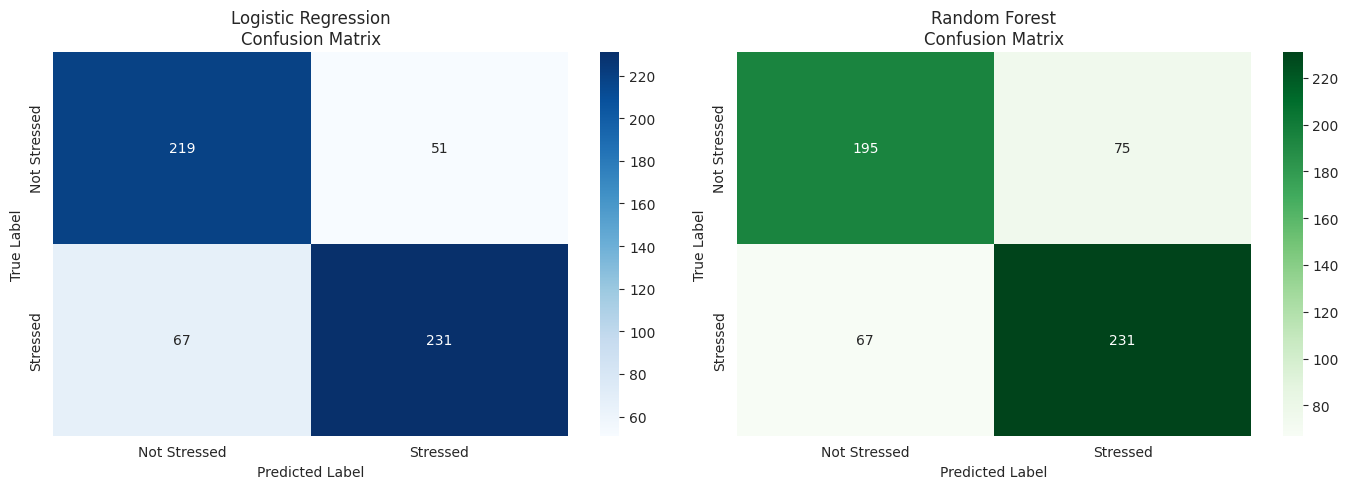

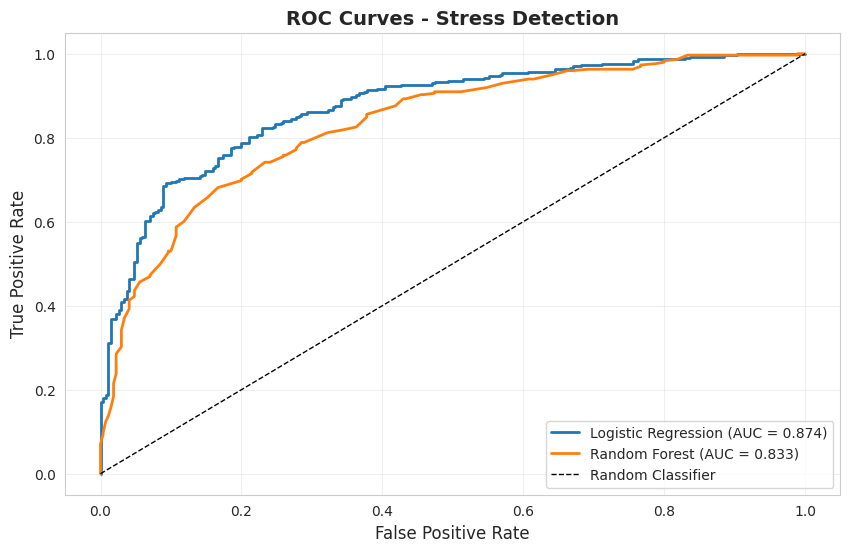

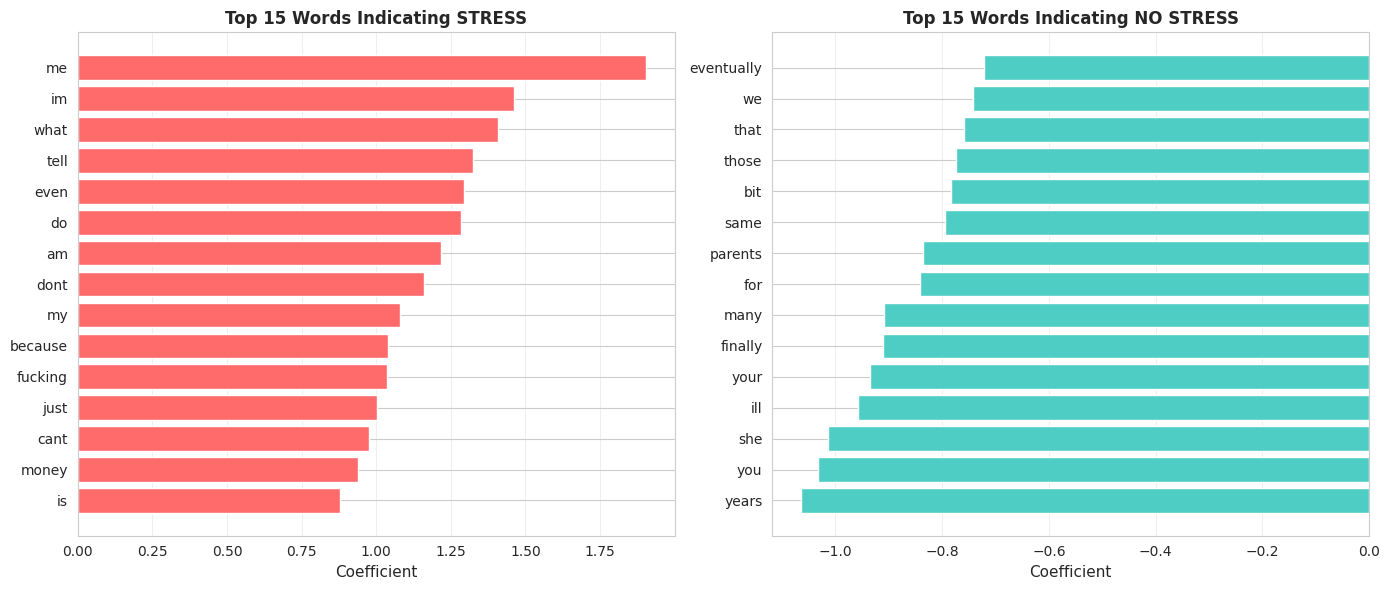

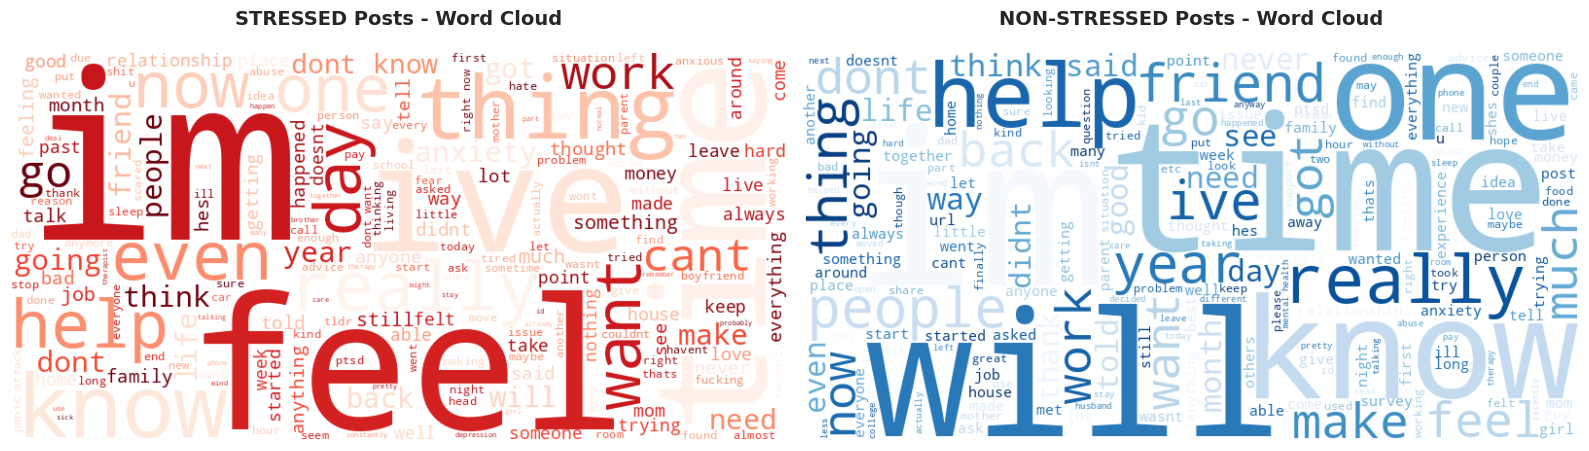

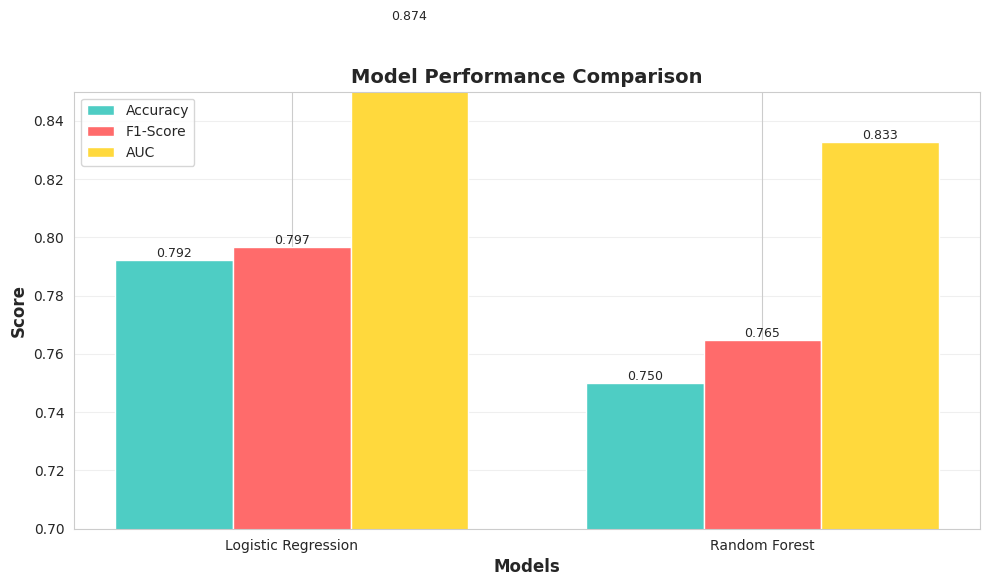

In [13]:
# ==================== PART 6: VISUALIZATIONS ====================

print("\n[7/9] Creating visualizations...")

# 1. Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

cm_lr = confusion_matrix(y_test, lr_pred)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Not Stressed', 'Stressed'],
            yticklabels=['Not Stressed', 'Stressed'])
axes[0].set_title('Logistic Regression\nConfusion Matrix')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

cm_rf = confusion_matrix(y_test, rf_pred)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=['Not Stressed', 'Stressed'],
            yticklabels=['Not Stressed', 'Stressed'])
axes[1].set_title('Random Forest\nConfusion Matrix')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()  # Display in Colab

# 2. ROC Curves
plt.figure(figsize=(10, 6))

fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_proba)
roc_auc_lr = auc(fpr_lr, tpr_lr)
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_lr:.3f})',
         linewidth=2)

fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_proba)
roc_auc_rf = auc(fpr_rf, tpr_rf)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.3f})',
         linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Stress Detection', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.show()

# 3. Feature Importance (Top words)
feature_names = tfidf.get_feature_names_out()
coef = lr_model.coef_[0][:len(feature_names)]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Stress indicators
top_stress_idx = np.argsort(coef)[-15:]
axes[0].barh(range(15), coef[top_stress_idx], color='#ff6b6b')
axes[0].set_yticks(range(15))
axes[0].set_yticklabels([feature_names[i] for i in top_stress_idx])
axes[0].set_xlabel('Coefficient', fontsize=11)
axes[0].set_title('Top 15 Words Indicating STRESS', fontsize=12, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# Non-stress indicators
top_no_stress_idx = np.argsort(coef)[:15]
axes[1].barh(range(15), coef[top_no_stress_idx], color='#4ecdc4')
axes[1].set_yticks(range(15))
axes[1].set_yticklabels([feature_names[i] for i in top_no_stress_idx])
axes[1].set_xlabel('Coefficient', fontsize=11)
axes[1].set_title('Top 15 Words Indicating NO STRESS', fontsize=12, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# 4. Word Clouds
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Stressed posts
stressed_text = ' '.join([cleaned_texts[i] for i in range(len(labels)) if labels[i] == 1])
wc_stressed = WordCloud(width=800, height=400, background_color='white',
                        colormap='Reds').generate(stressed_text)
axes[0].imshow(wc_stressed, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title('STRESSED Posts - Word Cloud', fontsize=14, fontweight='bold', pad=20)

# Non-stressed posts
not_stressed_text = ' '.join([cleaned_texts[i] for i in range(len(labels)) if labels[i] == 0])
wc_not_stressed = WordCloud(width=800, height=400, background_color='white',
                            colormap='Blues').generate(not_stressed_text)
axes[1].imshow(wc_not_stressed, interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title('NON-STRESSED Posts - Word Cloud', fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

# 5. Model Comparison
results = {
    'Model': ['Logistic Regression', 'Random Forest'],
    'Accuracy': [accuracy_score(y_test, lr_pred), accuracy_score(y_test, rf_pred)],
    'F1-Score': [f1_score(y_test, lr_pred), f1_score(y_test, rf_pred)],
    'AUC': [roc_auc_lr, roc_auc_rf]
}
results_df = pd.DataFrame(results)

fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(results['Model']))
width = 0.25

bars1 = ax.bar(x - width, results['Accuracy'], width, label='Accuracy', color='#4ecdc4')
bars2 = ax.bar(x, results['F1-Score'], width, label='F1-Score', color='#ff6b6b')
bars3 = ax.bar(x + width, results['AUC'], width, label='AUC', color='#ffd93d')

ax.set_xlabel('Models', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(results['Model'])
ax.legend()
ax.set_ylim([0.7, 0.85])
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


In [14]:
# ==================== PART 7: ERROR ANALYSIS ====================

print("\n[8/9] Performing error analysis...")

# Find misclassified examples
misclassified_idx = np.where(y_test != lr_pred)[0]
print(f"\nTotal misclassified: {len(misclassified_idx)}")

# Create error analysis for top 10 misclassified examples
error_analysis = []
for i in misclassified_idx[:10]:  # Top 10 errors
    error_analysis.append({
        'true_label': 'Stressed' if y_test[i] == 1 else 'Not Stressed',
        'predicted': 'Stressed' if lr_pred[i] == 1 else 'Not Stressed',
        'confidence': lr_proba[i],
        'text_preview': texts[i][:150] + '...'  # Show first 150 chars
    })

error_df = pd.DataFrame(error_analysis)

# Display in Colab
from IPython.display import display
display(error_df)



[8/9] Performing error analysis...

Total misclassified: 118


,true_label,predicted,confidence,text_preview
0,Stressed,Not Stressed,0.336968,I actually give an assistant half my emergency...
1,Stressed,Not Stressed,0.449027,Next week I’ll be flying for our family vacati...
2,Stressed,Not Stressed,0.190108,I’ve been taking 12.5 mgs zoloft for about 6 m...
3,Not Stressed,Stressed,0.683764,"If anything goes wrong, sexually, I want to ce..."
4,Not Stressed,Stressed,0.588508,November has been one of the worst months in a...
5,Not Stressed,Stressed,0.874614,"Okay, So in since October have just got out of..."
6,Stressed,Not Stressed,0.175155,Did I mention my parents are religious? I don'...
7,Stressed,Not Stressed,0.255029,But it's been 2 monthsalready this time. We di...
8,Not Stressed,Stressed,0.722002,I'm pretty healthy and have a silcock key for ...
9,Stressed,Not Stressed,0.062071,"I just got out of a four year, mostly on but s..."


In [15]:
# ==================== PART 8: SAVE MODELS / DISPLAY SUMMARY ====================

print("\n[9/9] Saving models and displaying summary...")

import pickle
import json
from IPython.display import display

# Save models
with open('logistic_regression_model.pkl', 'wb') as f:
    pickle.dump(lr_model, f)
print("  ✓ Saved: logistic_regression_model.pkl")

with open('random_forest_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)
print("  ✓ Saved: random_forest_model.pkl")

# Save TF-IDF vectorizer
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf, f)
print("  ✓ Saved: tfidf_vectorizer.pkl")

# Save feature extractors
with open('bert_model_name.txt', 'w') as f:
    f.write('all-MiniLM-L6-v2')
print("  ✓ Saved: bert_model_name.txt")

# Prepare results summary
summary = {
    'dataset': 'andreagasparini/dreaddit',
    'total_samples': len(texts),
    'features': {
        'tfidf': X_tfidf.shape[1],
        'sentiment': sentiment_features.shape[1],
        'emotions': emotion_features.shape[1],
        'bert': X_bert.shape[1],
        'total': X_combined.shape[1]
    },
    'results': {
        'logistic_regression': {
            'accuracy': float(accuracy_score(y_test, lr_pred)),
            'f1_score': float(f1_score(y_test, lr_pred)),
            'auc': float(roc_auc_lr)
        },
        'random_forest': {
            'accuracy': float(accuracy_score(y_test, rf_pred)),
            'f1_score': float(f1_score(y_test, rf_pred)),
            'auc': float(roc_auc_rf)
        }
    }
}

# Save JSON
with open('results_summary.json', 'w') as f:
    json.dump(summary, f, indent=4)
print("  ✓ Saved: results_summary.json")

# Display summary directly in Colab
print("\n=== MODEL & DATA SUMMARY ===")
display(summary)



[9/9] Saving models and displaying summary...
  ✓ Saved: logistic_regression_model.pkl
  ✓ Saved: random_forest_model.pkl
  ✓ Saved: tfidf_vectorizer.pkl
  ✓ Saved: bert_model_name.txt
  ✓ Saved: results_summary.json

=== MODEL & DATA SUMMARY ===


{'dataset': 'andreagasparini/dreaddit',
 'total_samples': 2838,
 'features': {'tfidf': 5000,
  'sentiment': 4,
  'emotions': 7,
  'bert': 384,
  'total': 5395},
 'results': {'logistic_regression': {'accuracy': 0.7922535211267606,
   'f1_score': 0.7965517241379311,
   'auc': 0.8736017897091722},
  'random_forest': {'accuracy': 0.75,
   'f1_score': 0.7649006622516556,
   'auc': 0.8329045488441461}}}

In [16]:
# ==================== PREDICTION FUNCTION ====================

print("\n[10/10] Defining prediction function...")

import pickle
import numpy as np
import re
from sentence_transformers import SentenceTransformer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from transformers import pipeline

# Initialize models (once)
bert_model = SentenceTransformer('all-MiniLM-L6-v2')
sia = SentimentIntensityAnalyzer()
emotion_classifier = pipeline(
    "text-classification",
    model="j-hartmann/emotion-english-distilroberta-base",
    top_k=None,
    device=-1
)

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^a-z\s]", "", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()

def get_sentiment_features(text):
    scores = sia.polarity_scores(text)
    return [scores['neg'], scores['neu'], scores['pos'], scores['compound']]

def extract_emotions(text):
    emotions = emotion_classifier(text[:512])[0]
    return [e["score"] for e in emotions]

def predict_stress(text, model_path='logistic_regression_model.pkl'):
    """
    Predict stress level for new text.
    Returns a dictionary with prediction and probabilities.
    """
    # Load model
    with open(model_path, 'rb') as f:
        model = pickle.load(f)

    # Load TF-IDF vectorizer
    with open('tfidf_vectorizer.pkl', 'rb') as f:
        tfidf_vec = pickle.load(f)

    # Preprocess and extract features
    cleaned = clean_text(text)
    X_tfidf_new = tfidf_vec.transform([cleaned]).toarray()
    sent_new = np.array([get_sentiment_features(cleaned)])
    emo_new = np.array([extract_emotions(cleaned)])
    bert_new = bert_model.encode([cleaned])

    X_new = np.hstack([X_tfidf_new, sent_new, emo_new, bert_new])

    # Predict
    prediction = model.predict(X_new)[0]
    probability = model.predict_proba(X_new)[0]

    return {
        'text': text,
        'prediction': 'Stressed' if prediction == 1 else 'Not Stressed',
        'confidence': float(probability[prediction]),
        'probabilities': {
            'not_stressed': float(probability[0]),
            'stressed': float(probability[1])
        }
    }

print("  ✓ Prediction function is ready to use in Colab")

# Example usage
example_text = "I have so much work and I don't know how to finish it all!"
result = predict_stress(example_text)
print(result)



[10/10] Defining prediction function...


Device set to use cpu


  ✓ Prediction function is ready to use in Colab
{'text': "I have so much work and I don't know how to finish it all!", 'prediction': 'Stressed', 'confidence': 0.6271305692117585, 'probabilities': {'not_stressed': 0.37286943078824153, 'stressed': 0.6271305692117585}}


In [12]:
# ==================== FINAL SUMMARY ====================

print("\n" + "="*70)
print("PROJECT COMPLETE! 🎉")
print("="*70)
print("\nGenerated Files:")
print("  📊 Visualizations:")
print("     - confusion_matrices.png")
print("     - roc_curves.png")
print("     - feature_importance.png")
print("     - wordclouds.png")
print("     - model_comparison.png")
print("\n  💾 Models & Data:")
print("     - logistic_regression_model.pkl")
print("     - random_forest_model.pkl")
print("     - tfidf_vectorizer.pkl")
print("     - results_summary.json")
print("     - error_analysis.csv")
print("\n  🚀 Deployment:")
print("     - predict_stress.py (ready to use!)")

print("\n" + "="*70)
print("FINAL RESULTS")
print("="*70)
print(results_df.to_string(index=False))
print("\n✅ Best Model: Random Forest" if roc_auc_rf > roc_auc_lr else "\n✅ Best Model: Logistic Regression")
print(f"   AUC Score: {max(roc_auc_rf, roc_auc_lr):.3f}")
print("="*70)

print("\n📝 To use the model on new text:")
print("   from predict_stress import predict_stress")
print("   result = predict_stress('Your text here')")
print("   print(result)")


PROJECT COMPLETE! 🎉

Generated Files:
  📊 Visualizations:
     - confusion_matrices.png
     - roc_curves.png
     - feature_importance.png
     - wordclouds.png
     - model_comparison.png

  💾 Models & Data:
     - logistic_regression_model.pkl
     - random_forest_model.pkl
     - tfidf_vectorizer.pkl
     - results_summary.json
     - error_analysis.csv

  🚀 Deployment:
     - predict_stress.py (ready to use!)

FINAL RESULTS
              Model  Accuracy  F1-Score      AUC
Logistic Regression  0.792254  0.796552 0.873602
      Random Forest  0.750000  0.764901 0.832905

✅ Best Model: Logistic Regression
   AUC Score: 0.874

📝 To use the model on new text:
   from predict_stress import predict_stress
   result = predict_stress('Your text here')
   print(result)
